In [136]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

train_dir = 'd:/pj/CellData/chest_xray/train'
test_dir='d:/pj/CellData/chest_xray/test'


In [137]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (299,299)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=0,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            subset='training')


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            seed=0,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=0,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            subset='validation')


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 624 files belonging to 2 classes.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


In [138]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터셋에 cache 및 prefetch 적용
train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [139]:
# Create the base model from the pre-trained model inception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,    # False로 하면 내 맘대로 input사진의 크기를 지정할수 있고,  마지막의  output하는 갯수도 지정가능
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='sigmoid'
)

In [140]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [141]:
base_model.trainable = False

In [142]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [143]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [144]:
inputs = tf.keras.Input(shape=(299, 299, 3))

# 증강
# x = data_augmentation(inputs)

# 정규화 (-1~1사이로)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input   # input값을 -1~1사이로 변경함.  rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
x = preprocess_input(inputs)

#  모바일넷 전이학습 모델 추가 (include_top=False 를 하였기 때문에 가장상단의 input 제외하고, 하단의 flatten부터 output까지 제외)
x = base_model(x, training=False)   # 베이스모델에 증강하고,  /127.5 -1 하여서  -1~1사이값으로 정규화한 데이터를 넣음



# flatten과 같은 역할임... https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   
x = global_average_layer(x)   #flatten 레이어를 추가해도됨.

# dropout과 튜닝

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)


# 최종출력레이어

prediction_layer = tf.keras.layers.Dense(1)
outputs = prediction_layer(x)

last_model = tf.keras.Model(inputs, outputs)

In [145]:
base_learning_rate = 0.0001
last_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [146]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
# modelpath="d:/pj/bestmodel1.h5"
modelpath="d:/pj/i200sgd0.0001.h5"

# 최적화 모델을 업데이트하고 저장합니다.


checkpointer = ModelCheckpoint(filepath=modelpath, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True)


initial_epochs = 200
# 축약 실험 initial_epochs = 1

history = last_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks = [checkpointer]
                    ) 

Epoch 1/15


131/131 [==============================] - ETA: 0s - loss: 0.6115 - accuracy: 0.6228
Epoch 1: val_loss improved from inf to 0.50826, saving model to d:/pj\isgd0.0001.h5
131/131 [==============================] - 20s 131ms/step - loss: 0.6115 - accuracy: 0.6228 - val_loss: 0.5083 - val_accuracy: 0.7600
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7747
Epoch 2: val_loss improved from 0.50826 to 0.44311, saving model to d:/pj\isgd0.0001.h5
131/131 [==============================] - 17s 127ms/step - loss: 0.5081 - accuracy: 0.7747 - val_loss: 0.4431 - val_accuracy: 0.8298
Epoch 3/15
131/131 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.8321
Epoch 3: val_loss improved from 0.44311 to 0.38999, saving model to d:/pj\isgd0.0001.h5
131/131 [==============================] - 17s 127ms/step - loss: 0.4495 - accuracy: 0.8321 - val_loss: 0.3900 - val_accuracy: 0.8786
Epoch 4/15
131/131 [==============================] - ETA: 0s

In [155]:
# 모델 복원
last_model = tf.keras.models.load_model(modelpath)
last_model.summary()
base_learning_rate = 0.0001
last_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

loss, acc = last_model.evaluate(test_dataset, verbose=2)
print('Loss: ', loss)
print('Acc: ', acc)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                           

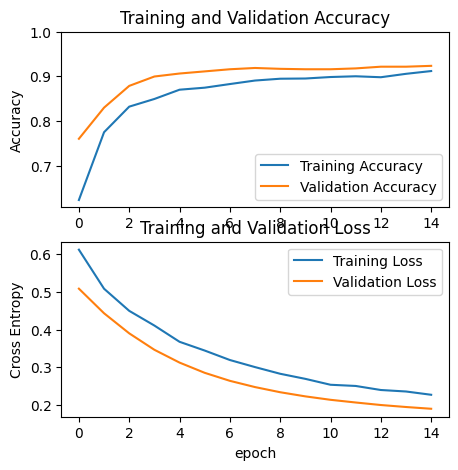

In [157]:
## 학습곡선그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 오차행렬표
- 테스트 자료를 이용해서 실제 y값하고 예측한 y값하고 비교함.
- 구글드라이브 딥러닝 - CNN - 3. Conv2D 소프트맥스 파일 참조

In [158]:
# 오차행렬과 분류리포트, 분류곡선

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [159]:
X_test,y_test=[],[]
for x, y in test_dataset:
    if len(y)==32:
        X_test.append(x.numpy())
        y_test.append(y.numpy())


X_test=np.reshape(X_test, (-1,299,299,3))
y_test=np.reshape(y_test,(-1))



In [160]:
yhat=last_model.predict(X_test)
yhat[yhat>=0.5]=1
yhat[yhat<0.5]=0
predict_y=yhat
real_y=y_test.copy()


In [161]:
# 오차행렬표임 (교재 388쪽의 하단내용)
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(real_y, predict_y)
conMatrix

array([[149,  77],
       [ 21, 361]], dtype=int64)

Text(33.22222222222222, 0.5, 'true label')

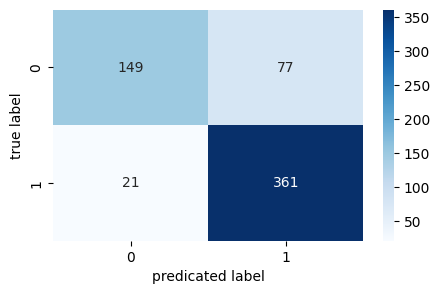

In [162]:
# 오차행렬표를 차트로 보여주는 작업_혼돈행렬
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [163]:
from sklearn.metrics import classification_report
print(classification_report(real_y, predict_y))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       226
           1       0.82      0.95      0.88       382

    accuracy                           0.84       608
   macro avg       0.85      0.80      0.82       608
weighted avg       0.84      0.84      0.83       608



## adam, learning rate 0.01 ##

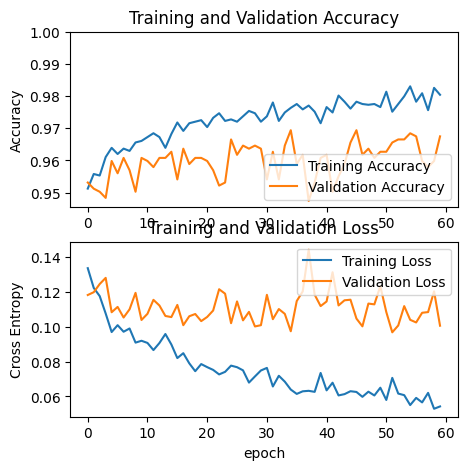
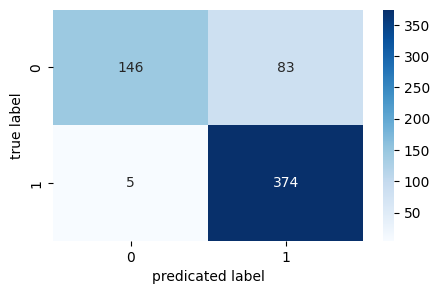



                precision    recall  f1-score   support

           0       0.97      0.64      0.77       229
           1       0.82      0.99      0.89       379

    accuracy                           0.86       608
   macro avg       0.89      0.81      0.83       608
weighted avg       0.87      0.86      0.85       608

## adam, learning rate 0.001 ## 

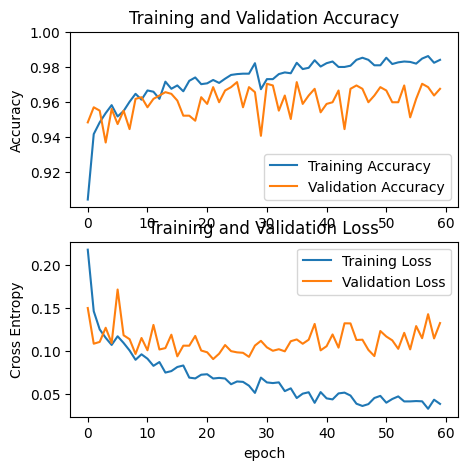
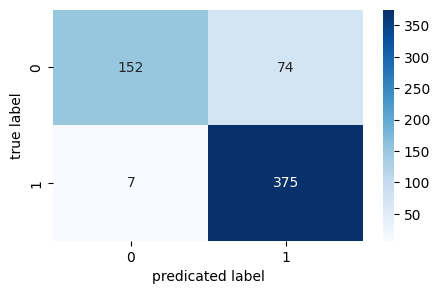

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       226
           1       0.84      0.98      0.90       382

    accuracy                           0.87       608
   macro avg       0.90      0.83      0.85       608
weighted avg       0.88      0.87      0.86       608


## adam, learning rate 0.0001 ## 

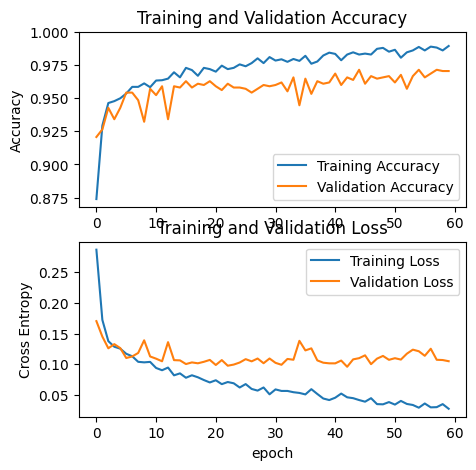
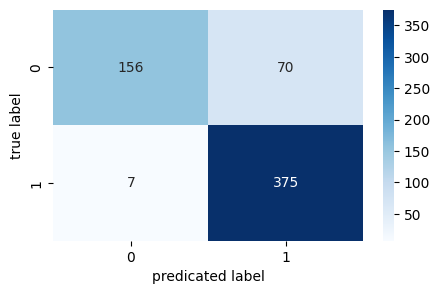



            precision    recall  f1-score   support

           0       0.96      0.69      0.80       226
           1       0.84      0.98      0.91       382

    accuracy                           0.87       608
   macro avg       0.90      0.84      0.85       608
weighted avg       0.89      0.87      0.87       608


## sgd, learning rate 0.0001 ## 

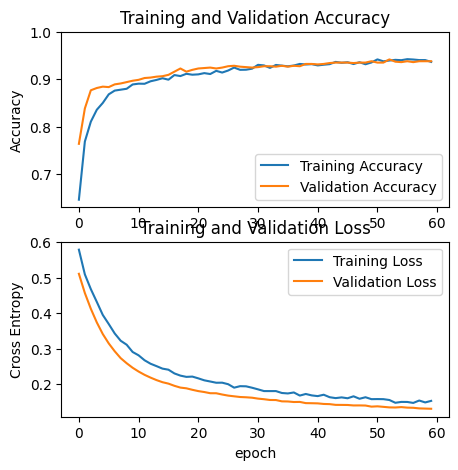
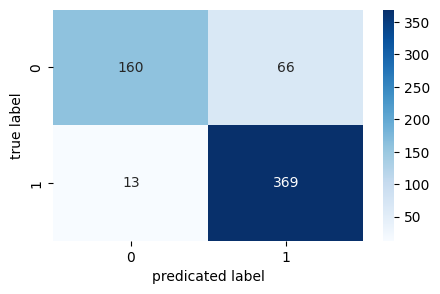



              precision    recall  f1-score   support

           0       0.92      0.71      0.80       226
           1       0.85      0.97      0.90       382

    accuracy                           0.87       608
   macro avg       0.89      0.84      0.85       608
weighted avg       0.88      0.87      0.87       608

## nadam, learning rate 0.0001 ## 

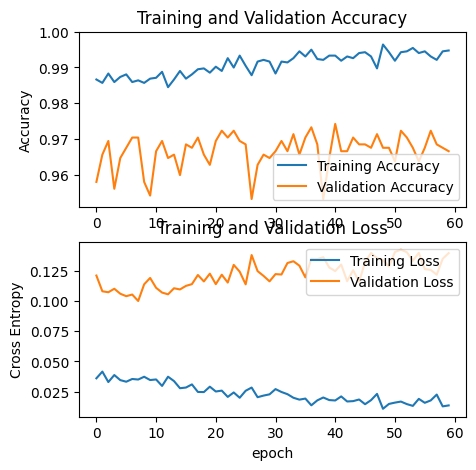
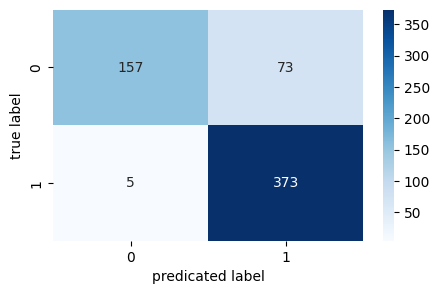

              precision    recall  f1-score   support

           0       0.97      0.68      0.80       230
           1       0.84      0.99      0.91       378

    accuracy                           0.87       608
   macro avg       0.90      0.83      0.85       608
weighted avg       0.89      0.87      0.87       608
